In [57]:
import mne

from mne.datasets import sample
from mne.decoding import GeneralizingEstimator

import pandas as pd
import numpy as np
import pickle as pkl
import scipy as sp
import mne
from os import path as op
from itertools import combinations
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from mne.io.constants import FIFF
from mne.decoding import (
    CSP,
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)

# from mne.stats import spatio_temporal_cluster_1samp_test
from scipy import stats as stats
from glob import glob

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, train_test_split,permutation_test_score
from xgboost import XGBClassifier, XGBRegressor

# Load Results

In [58]:
# load data
data_dir = '/scratch/users/ethanroy/eeg_groupitizing_data/results/classification_results'

files = glob(op.join(data_dir,'ENI_2*.pkl'))

subs_dict = {}

for file in files:
    
    subjectID = file.split('/')[-1][0:7]
    
    print(f"Loading {subjectID}")
    # Load data for pilot 1
    with open(file, 'rb') as f:
        ind_dict = pkl.load(f)
        subs_dict[subjectID] = ind_dict

Loading ENI_218
Loading ENI_203
Loading ENI_208
Loading ENI_201
Loading ENI_211
Loading ENI_222
Loading ENI_206
Loading ENI_209
Loading ENI_200
Loading ENI_213
Loading ENI_212
Loading ENI_217
Loading ENI_219
Loading ENI_205
Loading ENI_207
Loading ENI_210
Loading ENI_202


In [59]:
overall_acc_df = pd.DataFrame()
overall_acc_df_wide = pd.DataFrame()

epochs = {'sol':'solution','eq':'equals'}

for sub in subs_dict.keys():
    for epoch in epochs.keys():
    
        sub_row = {'Participant':sub,
                   'epoch': epochs[epoch],
                   'scores': subs_dict[sub][f'mne_correct_results_{epoch}'][('correct','incorrect')]['score_list']
                  }

        # Concatenate the original DataFrame and the new row DataFrame
        overall_acc_df = pd.concat([overall_acc_df, pd.DataFrame([sub_row])], ignore_index=True)

# Expand the 'data_array' column into new individual columns
expanded_data = overall_acc_df['scores'].apply(pd.Series)


# Concatenate the new columns with the original DataFrame
overall_acc_df = pd.concat([overall_acc_df.drop('scores', axis=1), expanded_data], axis=1)



In [60]:
scores = np.array(overall_acc_df[overall_acc_df['epoch']=='solution'].drop(['epoch','Participant'], axis=1))-0.5

In [61]:
T_obs, clusters, cluster_p_values, H0 = mne.stats.spatio_temporal_cluster_1samp_test(
    scores, 
    threshold=0.0,   # or None, if you want it to choose adaptively
    tail=1,          # test if above chance (positive direction)
    n_permutations=5000,  # more for stability
    n_jobs=1         # parallelism if you like
)

cluster_p_values

stat_fun(H1): min=-1.852802797178621 max=3.867045955720127
Running initial clustering …
Found 19 clusters


100%|██████████| Permuting : 4999/4999 [00:00<00:00, 5488.13it/s]


array([1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 0.965 , 0.9562,
       0.9872, 1.    , 1.    , 0.9996, 0.933 , 1.    , 1.    , 1.    ,
       0.179 , 0.9914, 0.0594])

In [62]:
marginal_clusters = [cl[0] for cl, pval in zip(clusters, cluster_p_values) if pval < 0.1][0]

In [63]:
marginal_clusters = marginal_clusters.astype(float)*0.005-.150

In [64]:
# Suppose your dataframe is called df
df_long = overall_acc_df.melt(
    id_vars=["Participant", "epoch"],        # keep these fixed
    var_name="time",                         # old wide columns go here
    value_name="score"                       # values go here
)

# Optional: clean up "time" so it's just the number
df_long["time"] = (0.005*df_long["time"].astype(int))-.150

print(df_long.head(10))

  Participant     epoch  time     score
0     ENI_218  solution -0.15  0.518750
1     ENI_218    equals -0.15  0.493750
2     ENI_203  solution -0.15  0.587500
3     ENI_203    equals -0.15  0.450000
4     ENI_208  solution -0.15  0.575000
5     ENI_208    equals -0.15  0.500000
6     ENI_201  solution -0.15  0.533333
7     ENI_201    equals -0.15  0.608333
8     ENI_211  solution -0.15  0.418750
9     ENI_211    equals -0.15  0.531250


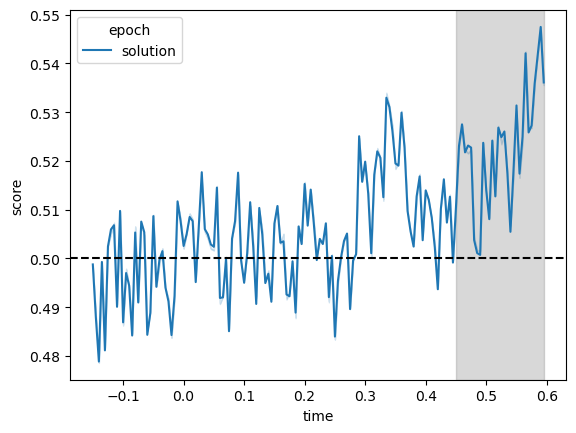

In [65]:
plt = sns.lineplot(data=df_long[df_long['epoch']=='solution'], x="time", y="score", hue="epoch",errorbar=('ci', 0.67))

plt.axhline(0.5, color="k", linestyle="--", label="chance")
plt.axvspan(min(marginal_clusters), max(marginal_clusters), color="gray", alpha=0.3)


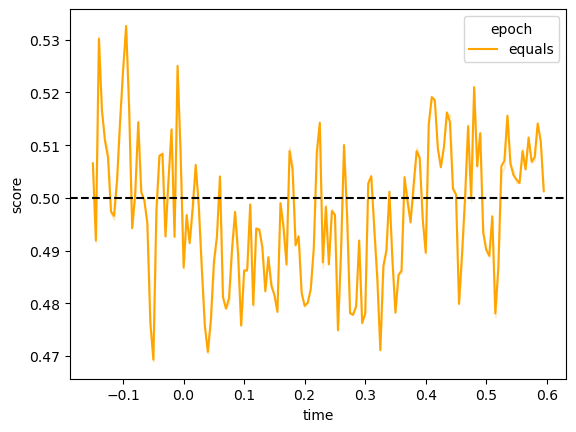

In [66]:
plt = sns.lineplot(data=df_long[df_long['epoch']=='equals'], x="time", y="score",
                   hue='epoch',palette=['orange'],errorbar=('ci', 0.67))

plt.axhline(0.5, color="k", linestyle="--", label="chance")


## Dot Accuracy

In [67]:
dot_acc_df = pd.DataFrame()

epochs = {'sol':'solution','eq':'equals'}

for sub in subs_dict.keys():
    for epoch in epochs.keys():
    
        sub_row = {'Participant':sub,
                   'epoch': epochs[epoch],
                   'scores': subs_dict[sub][f'mne_correct_results_{epoch}_dot'][('correct','incorrect')]['score_list']
                  }

        # Concatenate the original DataFrame and the new row DataFrame
        dot_acc_df = pd.concat([dot_acc_df, pd.DataFrame([sub_row])], ignore_index=True)

# Expand the 'data_array' column into new individual columns
expanded_data = dot_acc_df['scores'].apply(pd.Series)


# Concatenate the new columns with the original DataFrame
dot_acc_df = pd.concat([dot_acc_df.drop('scores', axis=1), expanded_data], axis=1)


In [68]:
scores = np.array(dot_acc_df[dot_acc_df['epoch']=='solution'].drop(['epoch','Participant'], axis=1))-0.5

In [69]:
T_obs, clusters, cluster_p_values, H0 = mne.stats.spatio_temporal_cluster_1samp_test(
    scores, 
    threshold=0.0,   # or None, if you want it to choose adaptively
    tail=1,          # test if above chance (positive direction)
    n_permutations=5000,  # more for stability
    n_jobs=1         # parallelism if you like
)

cluster_p_values

stat_fun(H1): min=-2.7649130823968653 max=3.498032121708419
Running initial clustering …
Found 23 clusters


100%|██████████| Permuting : 4999/4999 [00:00<00:00, 5427.88it/s]


array([1.    , 1.    , 1.    , 1.    , 0.9206, 1.    , 1.    , 1.    ,
       0.9358, 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 0.9996,
       0.452 , 1.    , 1.    , 1.    , 1.    , 0.9424, 0.4612])

In [15]:
marginal_clusters = [cl[0] for cl, pval in zip(clusters, cluster_p_values) if pval < 0.1][0]

IndexError: list index out of range

In [ ]:
marginal_clusters = marginal_clusters.astype(float)*0.005-.150

In [70]:
# Suppose your dataframe is called df
df_long = dot_acc_df.melt(
    id_vars=["Participant", "epoch"],        # keep these fixed
    var_name="time",                         # old wide columns go here
    value_name="score"                       # values go here
)

# Optional: clean up "time" so it's just the number
df_long["time"] = (0.005*df_long["time"].astype(int))-.150

print(df_long.head(10))

  Participant     epoch  time     score
0     ENI_218  solution -0.15  0.487500
1     ENI_218    equals -0.15  0.462500
2     ENI_203  solution -0.15  0.362500
3     ENI_203    equals -0.15  0.337500
4     ENI_208  solution -0.15  0.525000
5     ENI_208    equals -0.15  0.550000
6     ENI_201  solution -0.15  0.433333
7     ENI_201    equals -0.15  0.466667
8     ENI_211  solution -0.15  0.600000
9     ENI_211    equals -0.15  0.550000


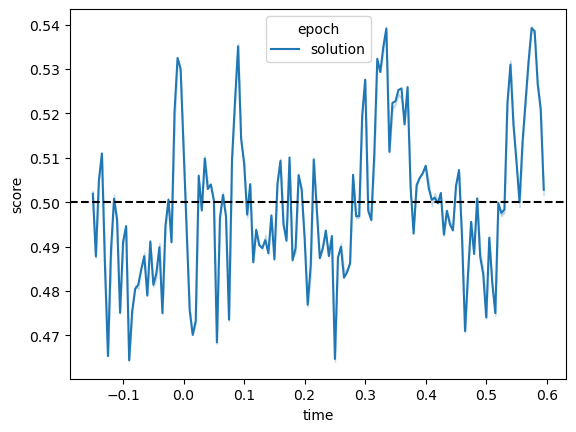

In [71]:
plt = sns.lineplot(data=df_long[df_long['epoch']=='solution'], x="time", y="score", hue="epoch",errorbar=('ci', 0.67))

plt.axhline(0.5, color="k", linestyle="--", label="chance")
# plt.axvspan(min(marginal_clusters), max(marginal_clusters), color="gray", alpha=0.3)


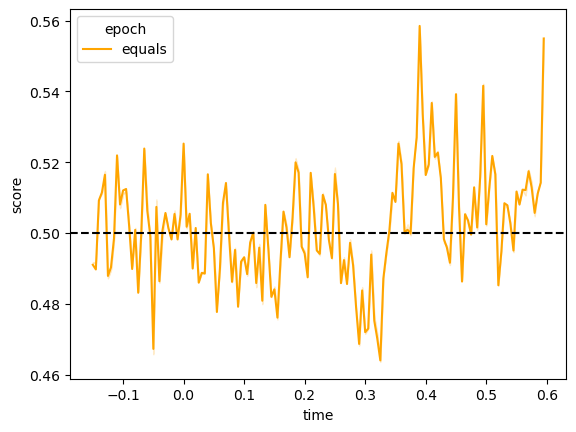

In [72]:
plt = sns.lineplot(data=df_long[df_long['epoch']=='equals'], x="time", y="score",
                   hue='epoch',palette=['orange'],errorbar=('ci', 0.67))

plt.axhline(0.5, color="k", linestyle="--", label="chance")


## Dot Generalizing


In [73]:
dot_gen_df = pd.DataFrame()

epochs = {'sol':'solution'}
forms = ['dot']

for sub in subs_dict.keys():
    for epoch in epochs.keys():
        for form in forms:
    
            sub_row = {'Participant':sub,
                       'epoch': epochs[epoch],
                       'scores': subs_dict[sub][f'mne_correct_results_{epoch}_{form}_train_gen'][('correct','incorrect')]['score_list']
                      }

            # Concatenate the original DataFrame and the new row DataFrame
            dot_gen_df = pd.concat([dot_gen_df, pd.DataFrame([sub_row])], ignore_index=True)

# Expand the 'data_array' column into new individual columns
expanded_data = dot_gen_df['scores'].apply(pd.Series)


# Concatenate the new columns with the original DataFrame
dot_gen_df = pd.concat([dot_gen_df.drop('scores', axis=1), expanded_data], axis=1)


In [74]:
scores = np.array(dot_gen_df[dot_gen_df['epoch']=='solution'].drop(['epoch','Participant'], axis=1))-0.5

In [75]:
T_obs, clusters, cluster_p_values, H0 = mne.stats.spatio_temporal_cluster_1samp_test(
    scores, 
    threshold=0.0,   # or None, if you want it to choose adaptively
    tail=1,          # test if above chance (positive direction)
    n_permutations=5000,  # more for stability
    n_jobs=1         # parallelism if you like
)

cluster_p_values

stat_fun(H1): min=-2.676756811267969 max=2.9520095933914816
Running initial clustering …
Found 25 clusters


100%|██████████| Permuting : 4999/4999 [00:00<00:00, 5423.83it/s]


array([1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 0.9986, 1.    ,
       1.    , 1.    , 0.999 , 1.    , 0.9986, 0.9998, 1.    , 0.9434,
       0.9142, 1.    , 1.    , 1.    , 0.996 , 0.3884, 0.9994, 0.159 ,
       0.9902])

In [23]:
marginal_clusters = [cl[0] for cl, pval in zip(clusters, cluster_p_values) if pval < 0.1][0]

IndexError: list index out of range

In [ ]:
marginal_clusters = marginal_clusters.astype(float)*0.005-.150

In [76]:
# Suppose your dataframe is called df
df_long = dot_gen_df.melt(
    id_vars=["Participant", "epoch"],        # keep these fixed
    var_name="time",                         # old wide columns go here
    value_name="score"                       # values go here
)

# Optional: clean up "time" so it's just the number
df_long["time"] = (0.005*df_long["time"].astype(int))-.150

print(df_long.head(10))

  Participant     epoch  time     score
0     ENI_218  solution -0.15  0.537500
1     ENI_203  solution -0.15  0.550000
2     ENI_208  solution -0.15  0.587500
3     ENI_201  solution -0.15  0.483333
4     ENI_211  solution -0.15  0.425000
5     ENI_222  solution -0.15  0.525000
6     ENI_206  solution -0.15  0.480000
7     ENI_209  solution -0.15  0.525000
8     ENI_200  solution -0.15  0.475000
9     ENI_213  solution -0.15  0.525000


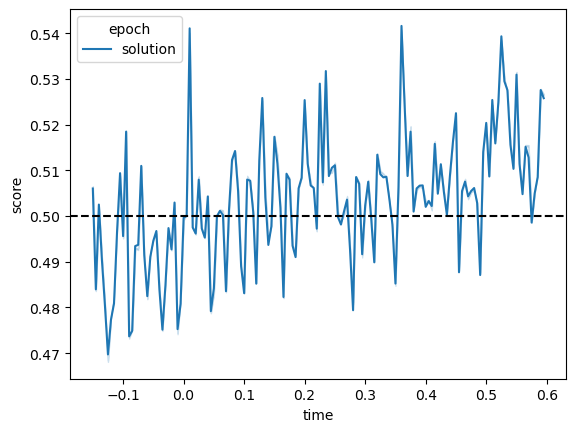

In [77]:
plt = sns.lineplot(data=df_long[df_long['epoch']=='solution'], x="time", y="score", hue="epoch",errorbar=('ci', 0.67))

plt.axhline(0.5, color="k", linestyle="--", label="chance")
# plt.axvspan(min(marginal_clusters), max(marginal_clusters), color="gray", alpha=0.3)


## Digit Accuracy

In [78]:
digit_acc_df = pd.DataFrame()

epochs = {'sol':'solution','eq':'equals'}

for sub in subs_dict.keys():
    for epoch in epochs.keys():
    
        sub_row = {'Participant':sub,
                   'epoch': epochs[epoch],
                   'scores': subs_dict[sub][f'mne_correct_results_{epoch}_digit'][('correct','incorrect')]['score_list']
                  }

        # Concatenate the original DataFrame and the new row DataFrame
        digit_acc_df = pd.concat([digit_acc_df, pd.DataFrame([sub_row])], ignore_index=True)

# Expand the 'data_array' column into new individual columns
expanded_data = digit_acc_df['scores'].apply(pd.Series)


# Concatenate the new columns with the original DataFrame
digit_acc_df = pd.concat([digit_acc_df.drop('scores', axis=1), expanded_data], axis=1)


In [79]:
scores = np.array(digit_acc_df[digit_acc_df['epoch']=='solution'].drop(['epoch','Participant'], axis=1))-0.5

In [80]:
T_obs, clusters, cluster_p_values, H0 = mne.stats.spatio_temporal_cluster_1samp_test(
    scores, 
    threshold=0.0,   # or None, if you want it to choose adaptively
    tail=1,          # test if above chance (positive direction)
    n_permutations=5000,  # more for stability
    n_jobs=1         # parallelism if you like
)

cluster_p_values

stat_fun(H1): min=-3.0696587267735587 max=3.084367480283078
Running initial clustering …
Found 17 clusters


100%|██████████| Permuting : 4999/4999 [00:00<00:00, 5513.61it/s]


array([1.    , 0.5804, 0.6928, 0.819 , 1.    , 0.9996, 0.7746, 1.    ,
       1.    , 0.7138, 1.    , 0.2476, 1.    , 0.987 , 0.3052, 0.21  ,
       0.1492])

In [81]:
marginal_clusters = [cl[0] for cl, pval in zip(clusters, cluster_p_values) if pval < 0.1][0]

IndexError: list index out of range

In [ ]:
marginal_clusters = marginal_clusters.astype(float)*0.005-.150

In [82]:
# Suppose your dataframe is called df
df_long = digit_acc_df.melt(
    id_vars=["Participant", "epoch"],        # keep these fixed
    var_name="time",                         # old wide columns go here
    value_name="score"                       # values go here
)

# Optional: clean up "time" so it's just the number
df_long["time"] = (0.005*df_long["time"].astype(int))-.150

print(df_long.head(10))

  Participant     epoch  time     score
0     ENI_218  solution -0.15  0.475000
1     ENI_218    equals -0.15  0.462500
2     ENI_203  solution -0.15  0.612500
3     ENI_203    equals -0.15  0.550000
4     ENI_208  solution -0.15  0.487500
5     ENI_208    equals -0.15  0.300000
6     ENI_201  solution -0.15  0.383333
7     ENI_201    equals -0.15  0.533333
8     ENI_211  solution -0.15  0.575000
9     ENI_211    equals -0.15  0.475000


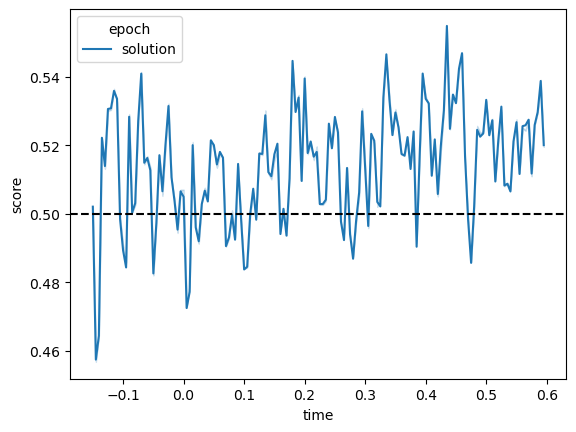

In [83]:
plt = sns.lineplot(data=df_long[df_long['epoch']=='solution'], x="time", y="score", hue="epoch",errorbar=('ci', 0.67))

plt.axhline(0.5, color="k", linestyle="--", label="chance")
# plt.axvspan(min(marginal_clusters), max(marginal_clusters), color="gray", alpha=0.3)


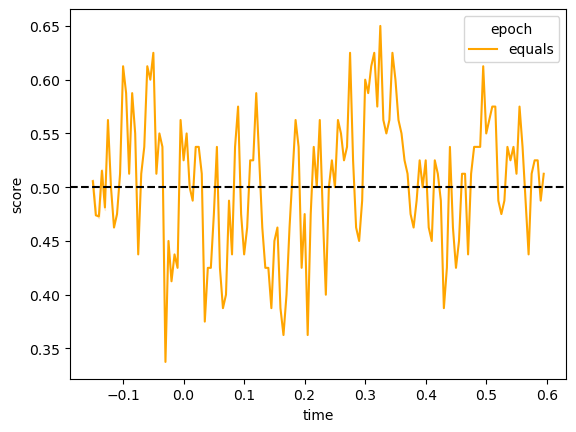

In [33]:
plt = sns.lineplot(data=df_long[df_long['epoch']=='equals'], x="time", y="score",
                   hue='epoch',palette=['orange'],errorbar=('ci', 0.67))

plt.axhline(0.5, color="k", linestyle="--", label="chance")


## Digit Generalizing

In [98]:
digit_gen_df = pd.DataFrame()

epochs = {'sol':'solution'}
forms = ['digit']

for sub in subs_dict.keys():
    for epoch in epochs.keys():
        for form in forms:
    
            sub_row = {'Participant':sub,
                       'epoch': epochs[epoch],
                       'scores': subs_dict[sub][f'mne_correct_results_{epoch}_{form}_train_gen'][('correct','incorrect')]['score_list']
                      }

            # Concatenate the original DataFrame and the new row DataFrame
            digit_gen_df = pd.concat([digit_gen_df, pd.DataFrame([sub_row])], ignore_index=True)

# Expand the 'data_array' column into new individual columns
expanded_data = digit_gen_df['scores'].apply(pd.Series)


# Concatenate the new columns with the original DataFrame
digit_gen_df = pd.concat([digit_gen_df.drop('scores', axis=1), expanded_data], axis=1)


In [99]:
scores = np.array(digit_gen_df[digit_gen_df['epoch']=='solution'].drop(['epoch','Participant'], axis=1))-0.5

In [100]:
T_obs, clusters, cluster_p_values, H0 = mne.stats.spatio_temporal_cluster_1samp_test(
    scores, 
    threshold=0.0,   # or None, if you want it to choose adaptively
    tail=1,          # test if above chance (positive direction)
    n_permutations=5000,  # more for stability
    n_jobs=1         # parallelism if you like
)

cluster_p_values

stat_fun(H1): min=-3.8770346493989876 max=3.1972092391419062
Running initial clustering …
Found 19 clusters


100%|██████████| Permuting : 4999/4999 [00:00<00:00, 5167.14it/s]


array([1.    , 1.    , 1.    , 1.    , 1.    , 0.9828, 1.    , 0.9386,
       0.8036, 1.    , 1.    , 1.    , 1.    , 0.2356, 0.44  , 0.757 ,
       0.3054, 0.998 , 0.222 ])

In [87]:
marginal_clusters = [cl[0] for cl, pval in zip(clusters, cluster_p_values) if pval < 0.1][0]

IndexError: list index out of range

In [88]:
marginal_clusters = marginal_clusters.astype(float)*0.005-.150

In [89]:
# Suppose your dataframe is called df
df_long = digit_gen_df.melt(
    id_vars=["Participant", "epoch"],        # keep these fixed
    var_name="time",                         # old wide columns go here
    value_name="score"                       # values go here
)

# Optional: clean up "time" so it's just the number
df_long["time"] = (0.005*df_long["time"].astype(int))-.150

print(df_long.head(10))

  Participant     epoch  time   score
0     ENI_218  solution -0.15  0.4750
1     ENI_203  solution -0.15  0.5625
2     ENI_208  solution -0.15  0.5250
3     ENI_201  solution -0.15  0.4500
4     ENI_211  solution -0.15  0.4750
5     ENI_222  solution -0.15  0.4750
6     ENI_206  solution -0.15  0.5200
7     ENI_209  solution -0.15  0.5125
8     ENI_200  solution -0.15  0.6000
9     ENI_213  solution -0.15  0.4875


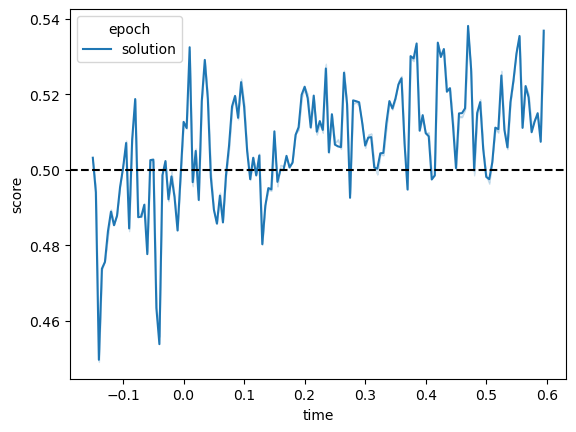

In [91]:
plt = sns.lineplot(data=df_long[df_long['epoch']=='solution'], x="time", y="score", hue="epoch",errorbar=('ci', 0.67))

plt.axhline(0.5, color="k", linestyle="--", label="chance")
# plt.axvspan(min(marginal_clusters), max(marginal_clusters), color="gray", alpha=0.3)


# Temporal Generalizing

In [92]:
temp_gen_df = pd.DataFrame()

epochs = {'sol':'solution'}
forms = ['digit','dot','combo']

combo_list = []
dot_list = []
digit_list = []

for sub in subs_dict.keys():
        
        combo_list.append(subs_dict[sub]['mne_solution_temp_gen_results'])
        dot_list.append(subs_dict[sub]['mne_solution_dot_temp_gen_results'])
        digit_list.append(subs_dict[sub]['mne_solution_digit_temp_gen_results'])


# Expand the 'data_array' column into new individual columns
mean_combo = np.mean(np.stack(combo_list, axis=0), axis=0)
mean_dot = np.mean(np.stack(dot_list, axis=0), axis=0)
mean_digit = np.mean(np.stack(digit_list, axis=0), axis=0)



In [93]:
times = np.array([(0.005*i)-.150 for i in range(0,mean_combo.shape[0])])
times[[0, -1, 0, -1]]

array([-0.15 ,  0.595, -0.15 ,  0.595])

### Combo

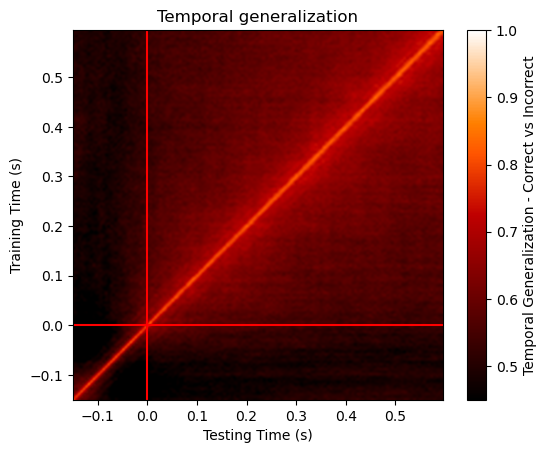

In [95]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
im = ax.imshow(
    mean_combo,
    interpolation="lanczos",
    origin="lower",
    cmap="gist_heat",
    extent=times[[0, -1, 0, -1]],
    vmin=0.45,
    vmax=1.0,
)
ax.set_xlabel("Testing Time (s)")
ax.set_ylabel("Training Time (s)")
ax.set_title("Temporal generalization")
ax.axvline(0, color="r")
ax.axhline(0, color="r")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Temporal Generalization - Correct vs Incorrect")

### Dots

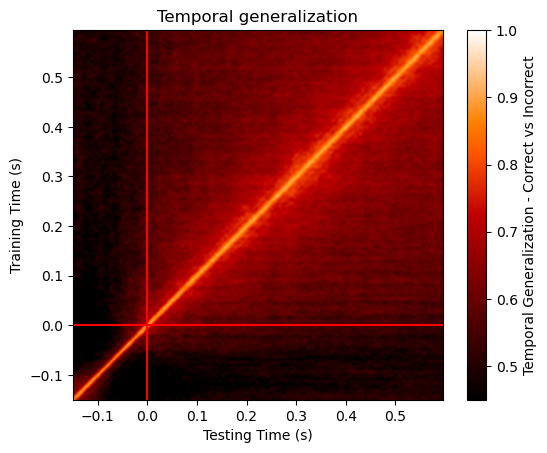

In [96]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(
    mean_dot,
    interpolation="lanczos",
    origin="lower",
    cmap="gist_heat",
    extent=times[[0, -1, 0, -1]],
    vmin=0.45,
    vmax=1.0,
)
ax.set_xlabel("Testing Time (s)")
ax.set_ylabel("Training Time (s)")
ax.set_title("Temporal generalization")
ax.axvline(0, color="r")
ax.axhline(0, color="r")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Temporal Generalization - Correct vs Incorrect")

### Digits

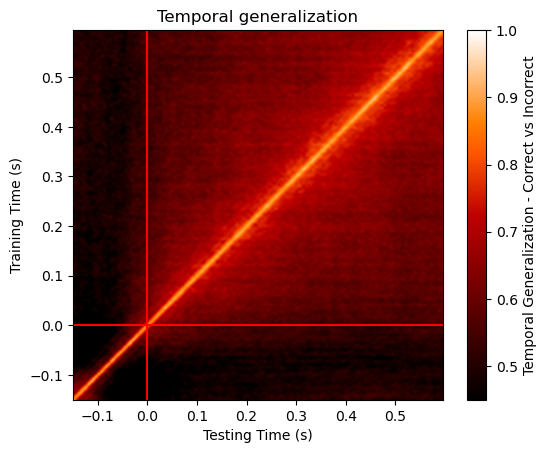

In [97]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(
    mean_digit,
    interpolation="lanczos",
    origin="lower",
    cmap="gist_heat",
    extent=times[[0, -1, 0, -1]],
    vmin=0.45,
    vmax=1.0,
)
ax.set_xlabel("Testing Time (s)")
ax.set_ylabel("Training Time (s)")
ax.set_title("Temporal generalization")
ax.axvline(0, color="r")
ax.axhline(0, color="r")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Temporal Generalization - Correct vs Incorrect")